In [1]:
# データ分析・操作用ライブラリ
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# NLP用ライブラリ
import MeCab,re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# スコア評価用ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

# 特徴量選択用
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# モデルの読み込み、保存
from sklearn.externals import joblib

# エラー表示の抑制
import warnings

D:\Program\Anaconda3\envs\sklearn1.9.1\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# 表示関連
# DataFrameの列数設定
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [3]:
# テキストデータの読み込み
wikiData = pd.read_csv("csv/train_cleaned.csv", encoding="utf-8")

# 読み込みデータの表示
wikiData.head()

,text,target
0,ドール・フード・カンパニー ドール・フード・カンパニー Dole Food Comp...,1
1,南ヶ丘牧場 株式会社 南ヶ丘牧場 みなみ じょう 栃木県 那須高原 本拠 酪...,1
2,岩瀬牧場 岩瀬牧場 ぼくじょう 日本 福島県 岩瀬 郡 鏡石町 牧場 鏡石...,1
3,くら ぎ GI Co Ltd 三重県 中心 農業 店舗 展開 会社 本...,1
4,ハッピーネモファーム 株式会社 ハッピーネモファーム 北海道 浦河 郡 浦河町 ...,1


In [4]:
# Numpy配列へ変換
X = wikiData.text.values
y = wikiData.target.values

In [5]:
# トレーニングデータ、テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# 形態素解析用関数
def tokenize(text):
    tokens = []
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in ['名詞'] :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [7]:
# CountVectorizerへ変換
vectorizer = joblib.load('model/CountVectorizer.pkl')
X_train = vectorizer.transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [8]:
# Light GBM
import lightgbm as lgb

clf = lgb.LGBMClassifier(objective='multiclass', num_class=33, random_state=42)

clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Training score：" + str(clf.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf.score(X_test, y_test)))

Training score：0.987232649498
Cross-Validation score：0.72053210518
Test score：0.733304233959


In [10]:
# 学習結果の保存
joblib.dump(clf, 'model/lgbm_CV.pkl')

['model/lgbm_CV.pkl']

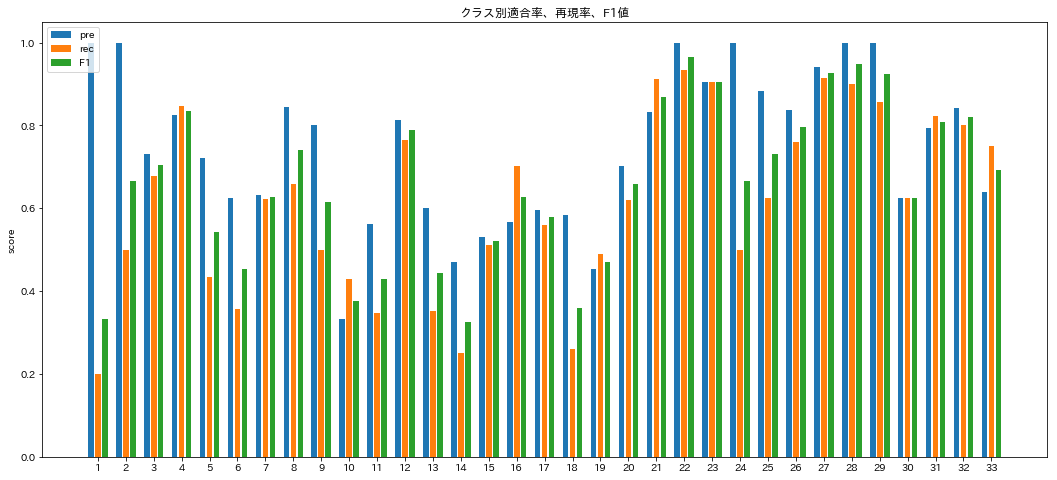

In [9]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)
wiki_gpby = wikiData.groupby('target').count()
y = wiki_gpby['text'].values
x =wiki_gpby.index.values

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()